In [1]:
import logging
import re
import os

import numpy as np
import tifffile
from ome_types import from_tiff, from_xml, to_xml, model, to_dict
from ome_types.model.simple_types import UnitsLength

from mip.utils import listfiles

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
from mip.ome import generate_ome_from_qptiff, generate_ome_from_codex_imagej_tif

In [15]:
codex_multiplexed_tif = '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT206B1-H1/level_2/20220106_HT206B1_H1_A1 and A4_reg001.tif'
output_fp = '/diskmnt/Projects/Users/estorrs/sandbox/test_old_codex.ome.tiff'

In [16]:
bbox = (5000, 6000, 5000, 6000)

In [34]:
generate_ome_from_codex_imagej_tif(codex_multiplexed_tif, output_fp, bbox=bbox)
# generate_ome_from_codex_imagej_tif(codex_multiplexed_tif, output_fp)

In [29]:
x = 'XYCZT'
x[:1:-1]

'TZC'

In [ ]:
[:1:-1]

In [18]:
??tifffile.TiffWriter

In [19]:
out_tif = tifffile.TiffWriter(output_fp, ome=True)

In [20]:
??out_tif.write

In [12]:
!which python

/diskmnt/Projects/Users/estorrs/miniconda3/envs/multiplex-imaging-pipeline/bin/python


In [26]:
img = tifffile.imread(codex_multiplexed_tif).astype(np.float32)
img /= img.max()
img.shape

(13, 4, 15120, 13440)

In [22]:
13 * 4

52

In [7]:
tf = tifffile.TiffFile(codex_multiplexed_tif)

In [11]:
s = tf.series[0]
s

<tifffile.TiffPageSeries 0>

In [13]:
len(s.pages)

1

In [15]:
p = s.pages[0]

In [16]:
p.description

'ImageJ=1.52i\nimages=52\nchannels=4\nframes=13\nhyperstack=true\nmode=composite\nunit=mm\nloop=false\nmin=511.0\nmax=52991.0'

In [17]:
p.description1

''

In [18]:
x = p.asarray()

In [23]:
tf.imagej_metadata

{'ImageJ': '1.52i',
 'images': 52,
 'channels': 4,
 'frames': 13,
 'hyperstack': True,
 'mode': 'composite',
 'unit': 'mm',
 'loop': False,
 'min': 511.0,
 'max': 52991.0,
 'Labels': ['DAPI-01',
  'Blank',
  'Blank',
  'Blank',
  'DAPI-02',
  'CD31',
  'E-cadherin',
  'CD4',
  'DAPI-03',
  'CD20',
  'Ki67',
  'CD68',
  'DAPI-04',
  'Pan-CK',
  'CD8',
  'Histone H3 Pho',
  'DAPI-05',
  'CD163',
  'Podoplanin',
  'CD3e',
  'DAPI-06',
  'CD36',
  'HIF1a',
  'GLUT1',
  'DAPI-07',
  'GATA3',
  'CD45RO',
  'CD45RA',
  'DAPI-08',
  'SMA',
  'CK19',
  'MGP',
  'DAPI-09',
  'Vimentin',
  'Maspin',
  'Foxp3',
  'DAPI-10',
  'Empty',
  'MMP9',
  'HLA-DR',
  'DAPI-11',
  'Empty',
  'CK14',
  'CD11c',
  'DAPI-12',
  'Empty',
  'CD44',
  'Empty',
  'DAPI-13',
  'Blank',
  'Blank',
  'Blank'],
 'Ranges': (0.0,
  57599.12109375,
  0.0,
  24575.625,
  0.0,
  58111.11328125,
  0.0,
  49663.2421875),
 'LUTs': [array([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
           13,  14,  1

In [27]:
img[0]

array([[[1.1444266e-03, 9.7657740e-04, 1.1139086e-03, ...,
         3.2043946e-04, 6.5613794e-04, 1.2207218e-04],
        [2.1972992e-03, 7.2632944e-03, 8.2398718e-04, ...,
         6.4087892e-04, 3.2043946e-04, 1.6784924e-04],
        [1.7242695e-03, 1.4038300e-03, 3.0518044e-04, ...,
         1.8310826e-04, 3.2043946e-04, 1.8310826e-04],
        ...,
        [0.0000000e+00, 6.1036088e-05, 3.0518044e-05, ...,
         1.3733120e-04, 1.6479744e-03, 6.9733732e-03],
        [7.6295109e-04, 1.1291676e-03, 6.1036088e-05, ...,
         5.9510185e-04, 9.2011904e-03, 1.3763638e-02],
        [1.6021973e-03, 8.2398718e-04, 1.8005646e-03, ...,
         1.9684138e-03, 7.7210651e-03, 5.9510185e-03]],

       [[2.2583352e-03, 2.1972992e-03, 4.1199359e-04, ...,
         1.8310826e-04, 2.1362631e-04, 2.5787747e-03],
        [9.6131838e-04, 7.9346914e-04, 1.0070954e-03, ...,
         4.8828870e-04, 1.3733120e-04, 4.2725261e-04],
        [5.3406577e-04, 4.5777066e-04, 1.3885710e-03, ...,
         1.709

In [29]:
import matplotlib.pyplot as plt

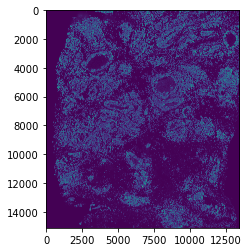

In [30]:
plt.imshow(img[0][0])

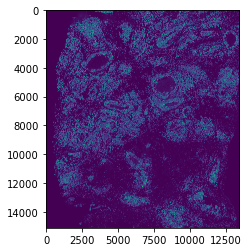

In [31]:
plt.imshow(img[5][0])

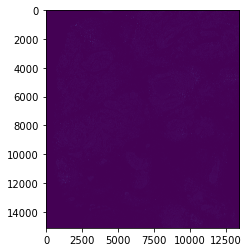

In [35]:
plt.imshow(img[10, 3])

In [24]:
channels = tf.imagej_metadata['Labels']
channels

['DAPI-01',
 'Blank',
 'Blank',
 'Blank',
 'DAPI-02',
 'CD31',
 'E-cadherin',
 'CD4',
 'DAPI-03',
 'CD20',
 'Ki67',
 'CD68',
 'DAPI-04',
 'Pan-CK',
 'CD8',
 'Histone H3 Pho',
 'DAPI-05',
 'CD163',
 'Podoplanin',
 'CD3e',
 'DAPI-06',
 'CD36',
 'HIF1a',
 'GLUT1',
 'DAPI-07',
 'GATA3',
 'CD45RO',
 'CD45RA',
 'DAPI-08',
 'SMA',
 'CK19',
 'MGP',
 'DAPI-09',
 'Vimentin',
 'Maspin',
 'Foxp3',
 'DAPI-10',
 'Empty',
 'MMP9',
 'HLA-DR',
 'DAPI-11',
 'Empty',
 'CK14',
 'CD11c',
 'DAPI-12',
 'Empty',
 'CD44',
 'Empty',
 'DAPI-13',
 'Blank',
 'Blank',
 'Blank']

In [67]:
keep_idxs, keep_channels = zip(*[(i, c) for i, c in enumerate(channels)
                     if c.lower()!='blank'
                     if c.lower()!='empty'
                     if c[:4]!='DAPI'])
keep_idxs = list(keep_idxs)
list(zip(keep_idxs, keep_channels))

[(5, 'CD31'),
 (6, 'E-cadherin'),
 (7, 'CD4'),
 (9, 'CD20'),
 (10, 'Ki67'),
 (11, 'CD68'),
 (13, 'Pan-CK'),
 (14, 'CD8'),
 (15, 'Histone H3 Pho'),
 (17, 'CD163'),
 (18, 'Podoplanin'),
 (19, 'CD3e'),
 (21, 'CD36'),
 (22, 'HIF1a'),
 (23, 'GLUT1'),
 (25, 'GATA3'),
 (26, 'CD45RO'),
 (27, 'CD45RA'),
 (29, 'SMA'),
 (30, 'CK19'),
 (31, 'MGP'),
 (33, 'Vimentin'),
 (34, 'Maspin'),
 (35, 'Foxp3'),
 (38, 'MMP9'),
 (39, 'HLA-DR'),
 (42, 'CK14'),
 (43, 'CD11c'),
 (46, 'CD44')]

In [64]:
data = rearrange(img, 'n_cycles n_per_cycle h w -> (n_cycles n_per_cycle) h w')
data.shape

(52, 15120, 13440)

In [66]:
keep_idxs

(5,
 6,
 7,
 9,
 10,
 11,
 13,
 14,
 15,
 17,
 18,
 19,
 21,
 22,
 23,
 25,
 26,
 27,
 29,
 30,
 31,
 33,
 34,
 35,
 38,
 39,
 42,
 43,
 46)

In [68]:
data = data[keep_idxs]
data.shape

(29, 15120, 13440)

In [72]:
np.expand_dims(img[0, 0], 0).shape

(1, 15120, 13440)

In [73]:
data = np.concatenate((np.expand_dims(img[0, 0], 0), data))
keep_idxs.insert(0, 'DAPI')
data.shape, len(keep_idxs)

((30, 15120, 13440), 30)

In [62]:
data[[1]]

array([[[0.00225834, 0.0021973 , 0.00041199, ..., 0.00018311,
         0.00021363, 0.00257877],
        [0.00096132, 0.00079347, 0.0010071 , ..., 0.00048829,
         0.00013733, 0.00042725],
        [0.00053407, 0.00045777, 0.00138857, ..., 0.00170901,
         0.00421149, 0.00039673],
        ...,
        [0.00045777, 0.00042725, 0.00062562, ..., 0.00016785,
         0.0003357 , 0.00015259],
        [0.00135805, 0.00054932, 0.0021973 , ..., 0.00021363,
         0.00105287, 0.0005951 ],
        [0.00061036, 0.00108339, 0.00201419, ..., 0.00112917,
         0.00064088, 0.00650034]]], dtype=float32)

In [61]:
data[keep_idxs]

KeyboardInterrupt: 

In [58]:
data = rearrange(img, 'n_cycles n_per_cycle h w -> (n_cycles n_per_cycle) h w')
data = data[np.asarray(keep_idxs)]

data.shape

KeyboardInterrupt: 

In [ ]:
pixel_type = 'uint8'
tf = tifffile.TiffFile(qptiff_fp)
s = tf.series[0] # full res tiffs are in the first series
n_channels = s.get_shape()[0]
shape = s.pages[0].shape
subresolutions = 5

bbox = (5000, 6000, 5000, 6000)
# bbox = None
shape

In [57]:
data.shape

(52, 15120, 13440)

In [13]:
qptiff_fp = '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/03172023_BRCA_HT397B1-U12/level_2/HT397B1-U12_Scan1.qptiff'
output_fp = '/diskmnt/Projects/Users/estorrs/sandbox/test_pyramidal.ome.tiff'
bbox = (5000, 6000, 5000, 6000)

In [14]:
generate_ome_from_qptiff(qptiff_fp, output_fp, bbox=bbox)

In [7]:
??generate_ome_from_qptiff

In [2]:
qptiff_fp = '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/03172023_BRCA_HT397B1-U12/level_2/HT397B1-U12_Scan1.qptiff'
# qptiff_fp = '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/040623_BRCA_HT397B1-U31/level_2/HT397B1-S1H1A3U31_Scan2.qptiff'

output_fp = '/diskmnt/Projects/Users/estorrs/sandbox/test_pyramidal.ome.tiff'
PHENOCYCLER_PIXELS_PER_MICRON = 1.9604911906033102


In [3]:
pixel_type = 'uint8'
tf = tifffile.TiffFile(qptiff_fp)
s = tf.series[0] # full res tiffs are in the first series
n_channels = s.get_shape()[0]
shape = s.pages[0].shape
subresolutions = 5

bbox = (5000, 6000, 5000, 6000)
# bbox = None
shape

(18720, 19200)

In [4]:
if bbox is None:
    data = np.zeros((shape[1], shape[0], n_channels, 1, 1),
                    dtype=np.uint8 if pixel_type=='uint8' else np.uint16)
else:
    data = np.zeros((bbox[3] - bbox[2], bbox[1] - bbox[0], n_channels, 1, 1),
                    dtype=np.uint8 if pixel_type=='uint8' else np.uint16)
biomarkers = []
for i, p in enumerate(s.pages):
    img = p.asarray()
    d = tifffile.xml2dict(p.description)['PerkinElmer-QPI-ImageDescription']
    biomarker = d['Biomarker']
    biomarkers.append(biomarker)
    if bbox is not None:
        r1, r2, c1, c2 = bbox
        y = r2 - r1
        x = c2 - c1
        img = img[r1:r2, c1:c2]
    img = img.astype(np.float32)
    img -= img.min()
    img /= img.max()
    if pixel_type == 'uint8':
        img *= 255
        img = img.astype(np.uint8)
    else:
        img *= 65535
        img = img.astype(np.uint16) 

    data[..., i, 0, 0] = np.swapaxes(img, 0, 1)
data.shape

(1000, 1000, 25, 1, 1)

In [5]:
o = model.OME()
o.images.append(
    model.Image(
        id='Image:0',
        pixels=model.Pixels(
            dimension_order='XYCZT',
            size_c=n_channels,
            size_t=1,
            size_x=data.shape[0],
            size_y=data.shape[1],
            size_z=data.shape[3],
            type=pixel_type,
            big_endian=False,
            channels=[model.Channel(id=f'Channel:{i}', name=c) for i, c in enumerate(biomarkers)],
            physical_size_x=1 / PHENOCYCLER_PIXELS_PER_MICRON,
            physical_size_y=1 / PHENOCYCLER_PIXELS_PER_MICRON,
            physical_size_x_unit='µm',
            physical_size_y_unit='µm'
        )
    )
)

im = o.images[0]
for i in range(len(im.pixels.channels)):
    im.pixels.planes.append(model.Plane(the_c=i, the_t=0, the_z=0))
im.pixels.tiff_data_blocks.append(model.TiffData(plane_count=len(im.pixels.channels)))
# xml_str = to_xml(o)
metadata = to_dict(to_xml(o))

/tmp/ipykernel_107137/2295163470.py:28: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  metadata = to_dict(to_xml(o))


In [8]:
from einops import rearrange
from skimage.transform import rescale

In [164]:
p = tf.pages[0]
p.compression

<COMPRESSION.LZW: 5>

In [ ]:
# !pip install imagecodecs==2023.3.16

In [9]:
with tifffile.TiffWriter(output_fp, ome=True, bigtiff=True) as out_tif:
    opts = {
        'compression': 'LZW',
    }
    out_tif.write(
        rearrange(data, 'x y c z t -> t c y x z'),
        subifds=subresolutions,
        **opts
    )
    for level in range(subresolutions):
        mag = 2**(level + 1)
        sampled = rescale(data[..., 0, 0], 1 / mag, preserve_range=True, channel_axis=-1)
        sampled = sampled.astype(np.uint8)
        sampled = np.expand_dims(sampled, (-2, -1))
        out_tif.write(
            rearrange(sampled, 'x y c z t -> t c y x z'),
            subfiletype=1,
            **opts
        )
    xml_str = to_xml(o)
    out_tif.overwrite_description(xml_str.encode())

In [129]:
to_dict(to_xml(o))

{'xmlns': 'http://www.openmicroscopy.org/Schemas/OME/2016-06',
 'xmlns:xsi': 'http://www.w3.org/2001/XMLSchema-instance',
 'xsi:schemaLocation': 'http://www.openmicroscopy.org/Schemas/OME/2016-06 http://www.openmicroscopy.org/Schemas/OME/2016-06/ome.xsd',
 'images': [{'id': 'Image:0',
   'pixels': {'big_endian': False,
    'dimension_order': 'XYCZT',
    'id': 'Pixels:8',
    'physical_size_x': 0.5100762527233116,
    'physical_size_y': 0.5100762527233116,
    'size_c': 25,
    'size_t': 1,
    'size_x': 1000,
    'size_y': 1000,
    'size_z': 1,
    'type': 'uint8',
    'physical_size_x_unit': 'µm',
    'physical_size_y_unit': 'µm',
    'physical_size_z_unit': 'µm',
    'time_increment_unit': 's',
    'channels': [{'color': -1,
      'id': 'Channel:0',
      'name': 'DAPI',
      'pinhole_size_unit': 'µm',
      'excitation_wavelength_unit': 'nm',
      'emission_wavelength_unit': 'nm'},
     {'color': -1,
      'id': 'Channel:1',
      'name': 'CD8',
      'pinhole_size_unit': 'µm',


In [32]:
f = open(qptiff_fp, 'rb')
import struct


In [43]:
f.seek(0)

0

In [44]:
header = f.read(4)
byteorder = {b'II': '<', b'MM': '>', b'EP': '<'}[header[:2]]
header, byteorder

(b'II+\x00', '<')

In [45]:
version = struct.unpack(byteorder + 'H', header[2:4])[0]
version

43

In [46]:
offsetsize, zero = struct.unpack(byteorder + 'HH', f.read(4))
offsetsize, zero

(8, 0)

In [56]:
from tifffile import TIFF, TiffPages, TiffPage

In [48]:
TIFF.BIG_LE

<tifffile.TiffFormat 64-bit little-endian>

In [ ]:
pages = TiffPages(self)

In [57]:
??TiffPage

In [53]:
f.seek(offsetsize)

8

In [58]:
from mip.ome import generate_ome_from_qptiff

In [60]:
generate_ome_from_qptiff(qptiff_fp, output_fp, bbox=bbox)

In [54]:
??TiffPage

Object `TiffPage` not found.


In [20]:
tif = TiffFile(qptiff_fp)
# ome = from_xml(tif.ome_metadata)
# im = ome.images[0]

In [23]:
ome = from_tiff(qptiff_fp, parser='lxml')

XMLSyntaxError: Document labelled UTF-16 but has UTF-8 content, line 1, column 38 (<string>, line 1)

In [18]:
from tifffile import TiffFile
from ome_types import from_tiff, from_xml

In [ ]:
tif = TiffFile(output_fp)
ome = from_xml(tif.ome_metadata)
im = ome.images[0]

In [ ]:
im

In [ ]:
im.pixels.channels

In [10]:
from mip.utils import extract_ome_tiff

In [11]:
d = extract_ome_tiff(output_fp)

/diskmnt/Projects/Users/estorrs/miniconda3/envs/multiplex-imaging-pipeline/lib/python3.9/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


In [12]:
d.keys()

dict_keys(['DAPI', 'CD8', 'Her2 (D)', 'GATA3 (D)', 'cKIT-(D)', 'Pan-Cytokeratin', 'GLUT1-(D)', 'Podoplanin', 'CD68 (D)', 'HLA-DR', 'Keratin 14', 'FoxP3', 'MGP-(D)', 'CD20-(D)', 'SMA-(D)', 'Ki67', 'Vimentin-(D)', 'PR-(D)', 'Bap1 (D)', 'CD45 (D)', 'ER', 'CD31', 'COX6c (D)', 'CK19', 'PLAT/tPA (D)'])